# Anomaly Detection Models

In [1]:
%matplotlib inline
import json, csv, sys, datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

from sklearn.decomposition import TruncatedSVD, PCA
from mpl_toolkits.mplot3d import Axes3D

from sklearn import cluster

from sklearn.neighbors import NearestNeighbors
import matplotlib.font_manager

from sklearn import svm
from sklearn.model_selection import train_test_split

This function extracts the features specified in the array from the json file provided to it and stores it in a csv file at the location provided to it. 

Edit the file locations (source json; destination csv) and run the code to generate the requisite datasets.

## Data Extraction

In [2]:

with open('../dataset/sample_first_50000.json', 'r') as file:
	i = 0
	j = 0
	# TODO: change list-based stuff to dict
	data = {}
	ipList = []
	# iterate over each logged line
	for line in file:
		newItem = {}
		try:
			jsonData = json.loads(line)
		except:
			print "\nLine {0} is not in JSON format".format(i)
			i += 1
			j += 1
			continue

		if 'data' in jsonData:
			timestamp = str(jsonData['data']['event_timestamp'])
			hour_of_the_day = (float(timestamp[11:13]) + float(timestamp[14:16])/60 + float(timestamp[17:19])/3600)
			# 0 - Monday; 6 - Sunday
			day_of_the_week = datetime.datetime(int(timestamp[:4]), \
				int(timestamp[5:7]), int(timestamp[8:10]), int(timestamp[11:13]), \
				int(timestamp[14:16]), int(timestamp[17:19])).weekday()
			newItem["hour_of_the_day"] = hour_of_the_day
			newItem["day_of_the_week"] = day_of_the_week
		
			featuresFromData = ["client_user", "client_host", "client_ip", "client_program", "CONNECT_DATA_INSTANCE_NAME", "service_name"]
			for feature in featuresFromData:
				if feature in jsonData['data']:
					newItem[feature] = str(jsonData['data'][feature])
				else:
					newItem[feature] = ""

		if 'metadata' in jsonData:
			featuresFromMetadata = ["oracle_sid", "hostname"]
			for feature in featuresFromMetadata:
				if feature in jsonData['metadata']:
					newItem[feature] = str(jsonData['metadata'][feature])
				else:
					newItem[feature] = ""

		# ignore cases where data is incomplete/very little to analyse
		if len(newItem) <= 2:
			continue

		else:
			data[i] = newItem
			ipList.append(newItem["client_ip"])
		# increment item number within the data
		i += 1

if j > 0:
	print "Could not store {0} lines due to invalid format".format(j)


Write the data extracted from the json file into a csv file

In [3]:
fieldNames = ['hour_of_the_day', 'day_of_the_week', 'client_user', 'client_host', 'client_ip', 'client_program', 'CONNECT_DATA_INSTANCE_NAME', 'service_name', 'oracle_sid', 'hostname']

with open('../dataset/preprocessed_first_50000.csv', 'w') as csvFile:
	writer = csv.DictWriter(csvFile, fieldnames=fieldNames)
	writer.writeheader()
	
	for item in data:
		writer.writerow(data[item])
print"Data written to file."

Data written to file.


Read in the data and store it in a dataframe

In [4]:
data = pd.read_csv('../dataset/preprocessed_first_50000.csv').fillna('0')
data = data.to_dict(orient='records')

## Preprocessing

DictVectorizer allows us to transform categorical data into numerical format

In [5]:
vec = DictVectorizer()
X = np.array(vec.fit_transform(data).toarray())

Robust Scaling works better for large sparse matrices (?)

In [6]:
X = preprocessing.robust_scale(X)
print "\nDimensions of feature matrix: ", X.shape
np.savetxt('../dataset/matX.txt', X)


Dimensions of feature matrix:  (50000, 588)


TruncatedSVD works better than PCA for our use-case

## PCA

In [7]:
pca_3 = PCA(n_components=3)
pca_3.fit(X)
X_pca_3 = pca_3.transform(X)
print "\nDimensions of feature matrix: ", X_pca_3.shape


Dimensions of feature matrix:  (50000, 3)


In [8]:
for i in xrange(len(X_pca_3)):
    if i > 6:
        break
    print X_pca_3[i, 0], X_pca_3[i, 1], X_pca_3[i, 2]

-2.72230617012 -1.34129018615 -0.0530768542367
-2.56731859261 1.48925831588 -1.29747864448
-2.72230617012 -1.34129018615 -0.0530768542367
-2.57056180681 1.50574272951 -1.33915945322
-2.72230617012 -1.34129018615 -0.0530768542367
-2.71756112461 -0.972549093232 -0.122880253415
-2.72230617012 -1.34129018615 -0.0530768542367


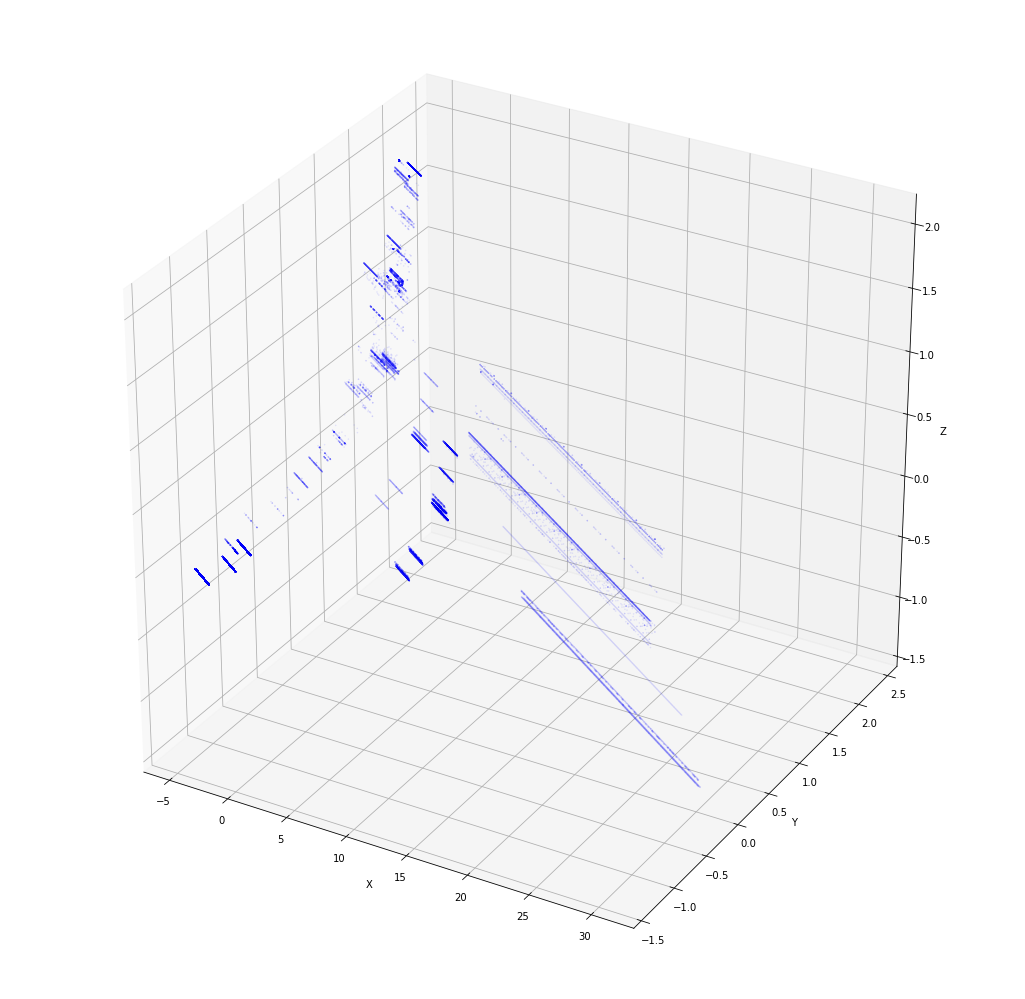

In [9]:
fig2 = plt.figure(figsize=(18, 18))
ax2 = fig2.add_subplot(111, projection='3d')

ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")

ax2.scatter(X_pca_3[:, 0], X_pca_3[:, 1], X_pca_3[:, 2], s=.3, alpha=.1, edgecolor='b', facecolor='w', color='k')



In [10]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print "\nDimensions of feature matrix: ", X_pca.shape


Dimensions of feature matrix:  (50000, 2)


In [11]:
for i in xrange(len(X_pca)):
    if i > 6:
        break
    print X_pca[i, 0], X_pca[i, 1]

-2.72230617012 -1.34129018615
-2.56731859261 1.48925831588
-2.72230617012 -1.34129018615
-2.57056180681 1.50574272951
-2.72230617012 -1.34129018615
-2.71756112461 -0.972549093232
-2.72230617012 -1.34129018615


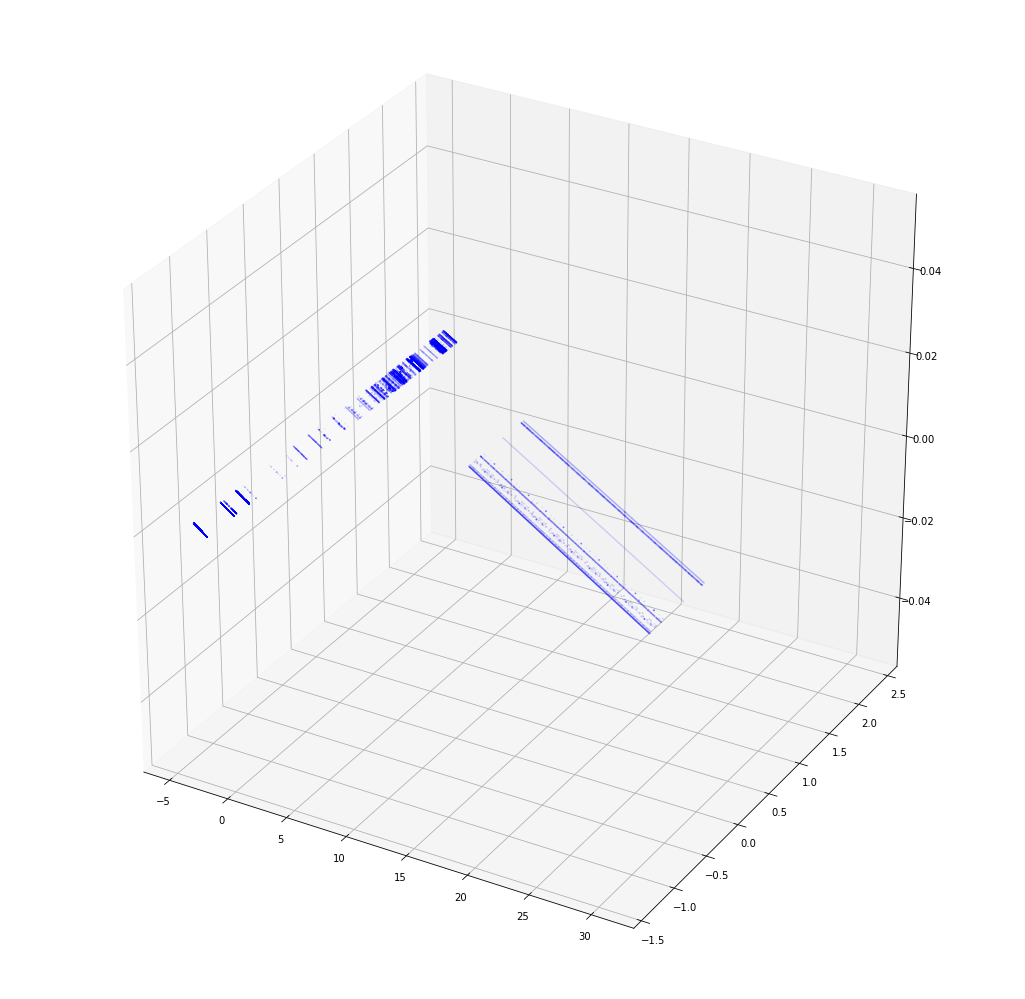

In [12]:
fig0000 = plt.figure(figsize=(18, 18))
ax0000 = fig0000.add_subplot(111, projection='3d')
ax0000.scatter(X_pca[:,0],X_pca[:,1], s=.3, alpha=.1, edgecolor='b', facecolor='w', color='k')

## SVD

In [13]:
svd_3 = TruncatedSVD(n_components=3)
X_svd_3 = svd_3.fit_transform(X)
print "\nDimensions of feature matrix: ", X_svd_3.shape


Dimensions of feature matrix:  (50000, 3)


In [14]:
for i in xrange(len(X_svd_3)):
    if i > 6:
        break
    print X_svd_3[i, 0], X_svd_3[i, 1], X_svd_3[i, 2]

0.523200203313 0.0847853832718 1.72175721571
0.753884693052 2.59676908807 0.371411435183
0.523200203313 0.084785383272 1.72175721571
0.751393988474 2.61604001052 0.375747155599
0.523200203313 0.084785383272 1.72175721571
0.502555054109 -0.00100148096523 0.639181560832
0.523200203313 0.084785383272 1.72175721571


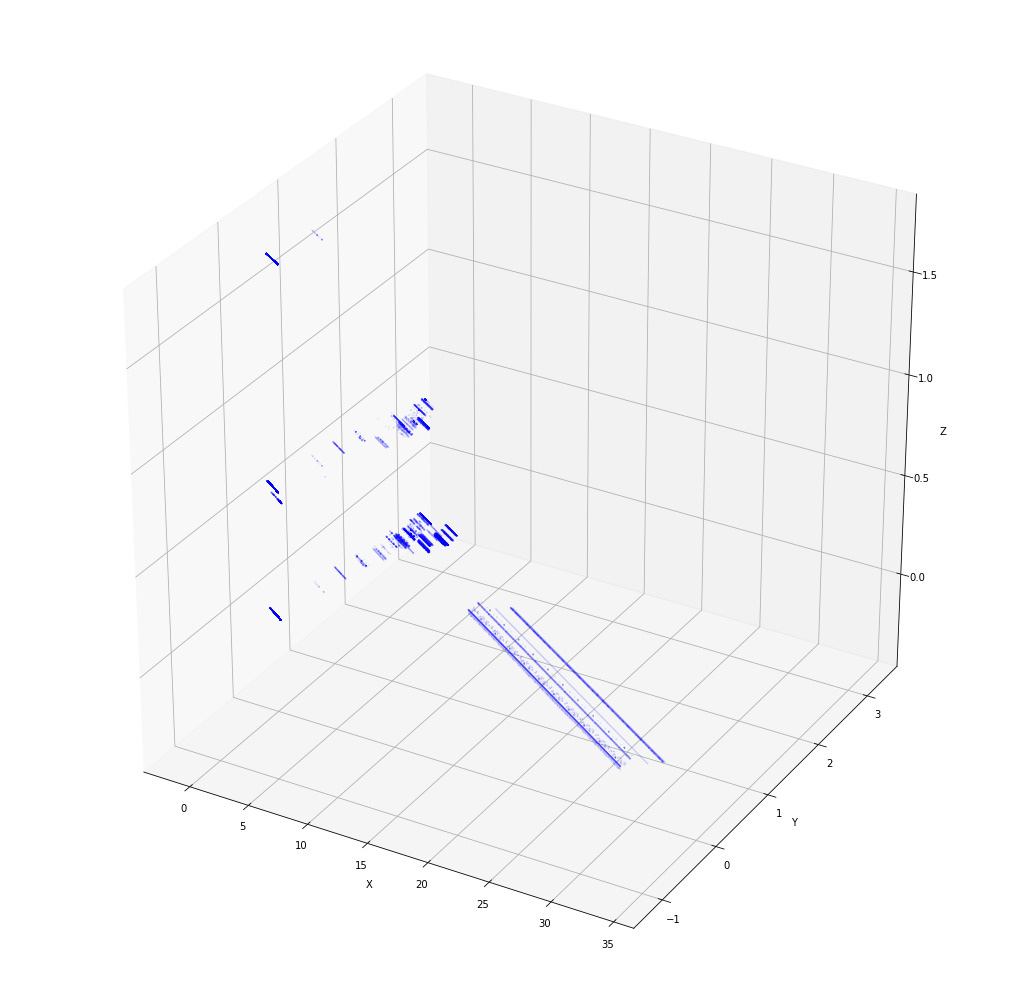

In [15]:
# Create figure, add subplot with 3d projection
fig000 = plt.figure(figsize=(18, 18))
ax000 = fig000.add_subplot(111, projection='3d')

ax000.set_xlabel("X")
ax000.set_ylabel("Y")
ax000.set_zlabel("Z")

# Plot the data cloud
ax000.scatter(X_svd_3[:, 0], X_svd_3[:, 1], X_svd_3[:, 2], s=.3, alpha=.1, edgecolor='b', facecolor='w', color='k')

In [16]:
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X)
print "\nDimensions of feature matrix: ", X_svd.shape


Dimensions of feature matrix:  (50000, 2)


In [17]:
for i in xrange(len(X_svd)):
    if i > 6:
        break
    print X_svd[i, 0], X_svd[i, 1]

0.523200203313 0.084785383871
0.753884693052 2.5967690867
0.523200203313 0.084785383871
0.751393988474 2.61604000878
0.523200203313 0.084785383871
0.502555054109 -0.00100148243052
0.523200203313 0.084785383871


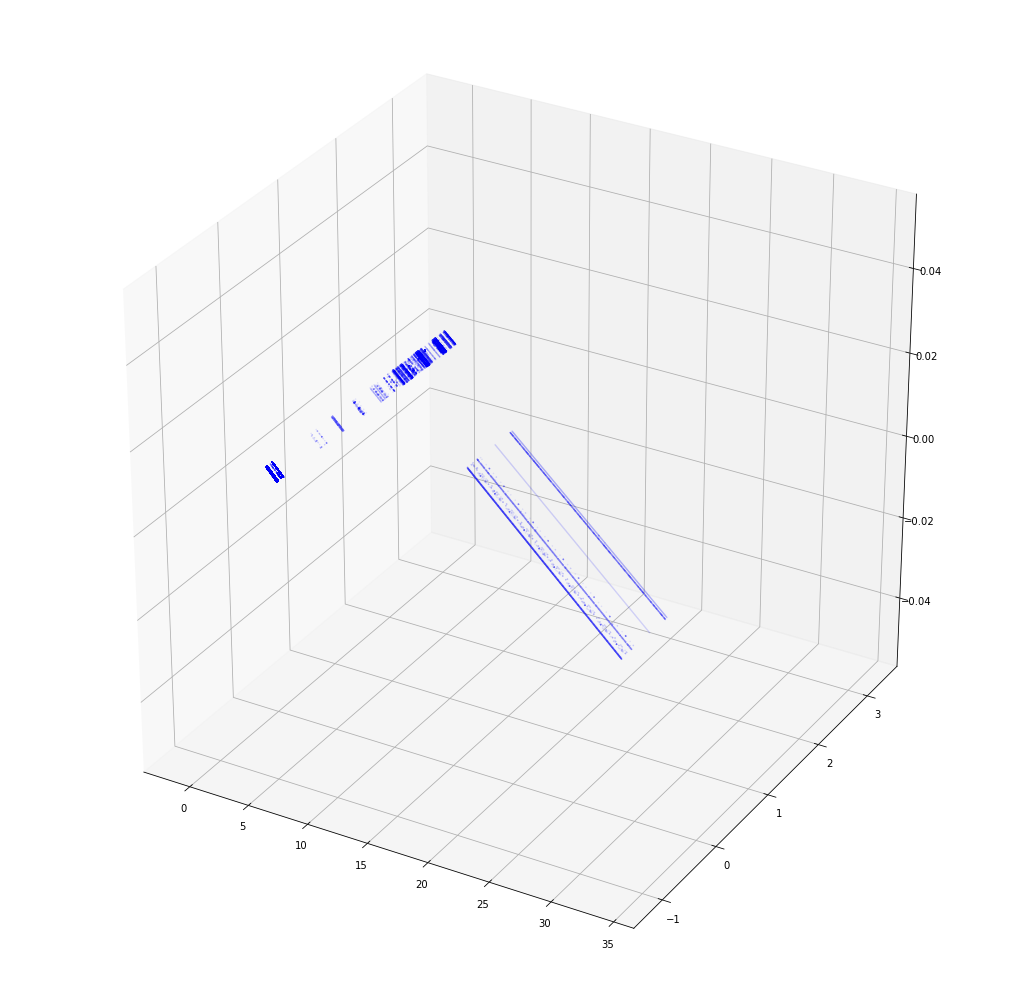

In [18]:
fig00 = plt.figure(figsize=(18, 18))
ax00 = fig00.add_subplot(111, projection='3d')
ax00.scatter(X_svd[:,0],X_svd[:,1], s=.3, alpha=.1, edgecolor='b', facecolor='w', color='k')

In [19]:
np.savetxt('../dataset/X_svd.txt', X_svd, delimiter=',')
np.savetxt('../dataset/X_svd_3.txt', X_svd_3, delimiter=',')
np.savetxt('../dataset/X_pca.txt', X_pca, delimiter=',')
np.savetxt('../dataset/X_pca_3.txt', X_pca_3, delimiter=',')